Backpack Prediction Challenge

2025 Kaggle Playground-Predict the price of backpacks given various attributes

Table of contents:
1. Setup
2. Exploratory analysis
3. Data cleaning
4. Feature engineering
5. Modeling
6. An ensemble model

Setup

Imports

In [24]:
# Load system libraries.
import os
import re
import sys
import collections
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import sklearn
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Machine learning.
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (3, 3)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

# Local modules.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load Data

In [25]:
train1 = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
train3 = pd.read_csv('data/Noisy_Student_Bag_Price_Prediction_Dataset.csv')
test = pd.read_csv('data/test.csv')
train_test = pd.concat([train1, test])

In [26]:
train1.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


Exploratory analysis

In [27]:
print('Numerical columns:')
display(train1.describe(include=np.number))
print('Numerical columns:')
display(train1.describe(exclude=np.number))
print('Missing Values:')
display(pd.concat([
  train1.iloc[:, 1:].isna().sum().rename('train'),
  test.isna().sum().rename('test')
], axis=1))

Numerical columns:


,id,Compartments,Weight Capacity (kg),Price
count,300000.000000,300000.000000,299862.000000,300000.000000
mean,149999.500000,5.443590,18.029994,81.411107
std,86602.684716,2.890766,6.966914,39.039340
min,0.000000,1.000000,5.000000,15.000000
25%,74999.750000,3.000000,12.097867,47.384620
50%,149999.500000,5.000000,18.068614,80.956120
75%,224999.250000,8.000000,24.002375,115.018160
max,299999.000000,10.000000,30.000000,150.000000


Numerical columns:


,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,290295,291653,293405,292556,292950,292030,290050
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,60077,79630,101906,148342,148077,100031,51690


Missing Values:


,train,test
Brand,9705.0,6227.0
Material,8347.0,5613.0
Size,6595.0,4381.0
Compartments,0.0,0.0
Laptop Compartment,7444.0,4962.0
Waterproof,7050.0,4811.0
Style,7970.0,5153.0
Color,9950.0,6785.0
Weight Capacity (kg),138.0,77.0
Price,0.0,NaN


Data includes 10 columns
Simple categocial values:waterproof, size, laptop compartment, 
Discrete values: compartments
Continuous values: weight capacity, price
More complex values: brand, material, style, colors

compartments and price dont have any missing values but everything else does

In [60]:
print(train1.columns)

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')


Simple categorical values

09:39:36 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
09:39:36 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


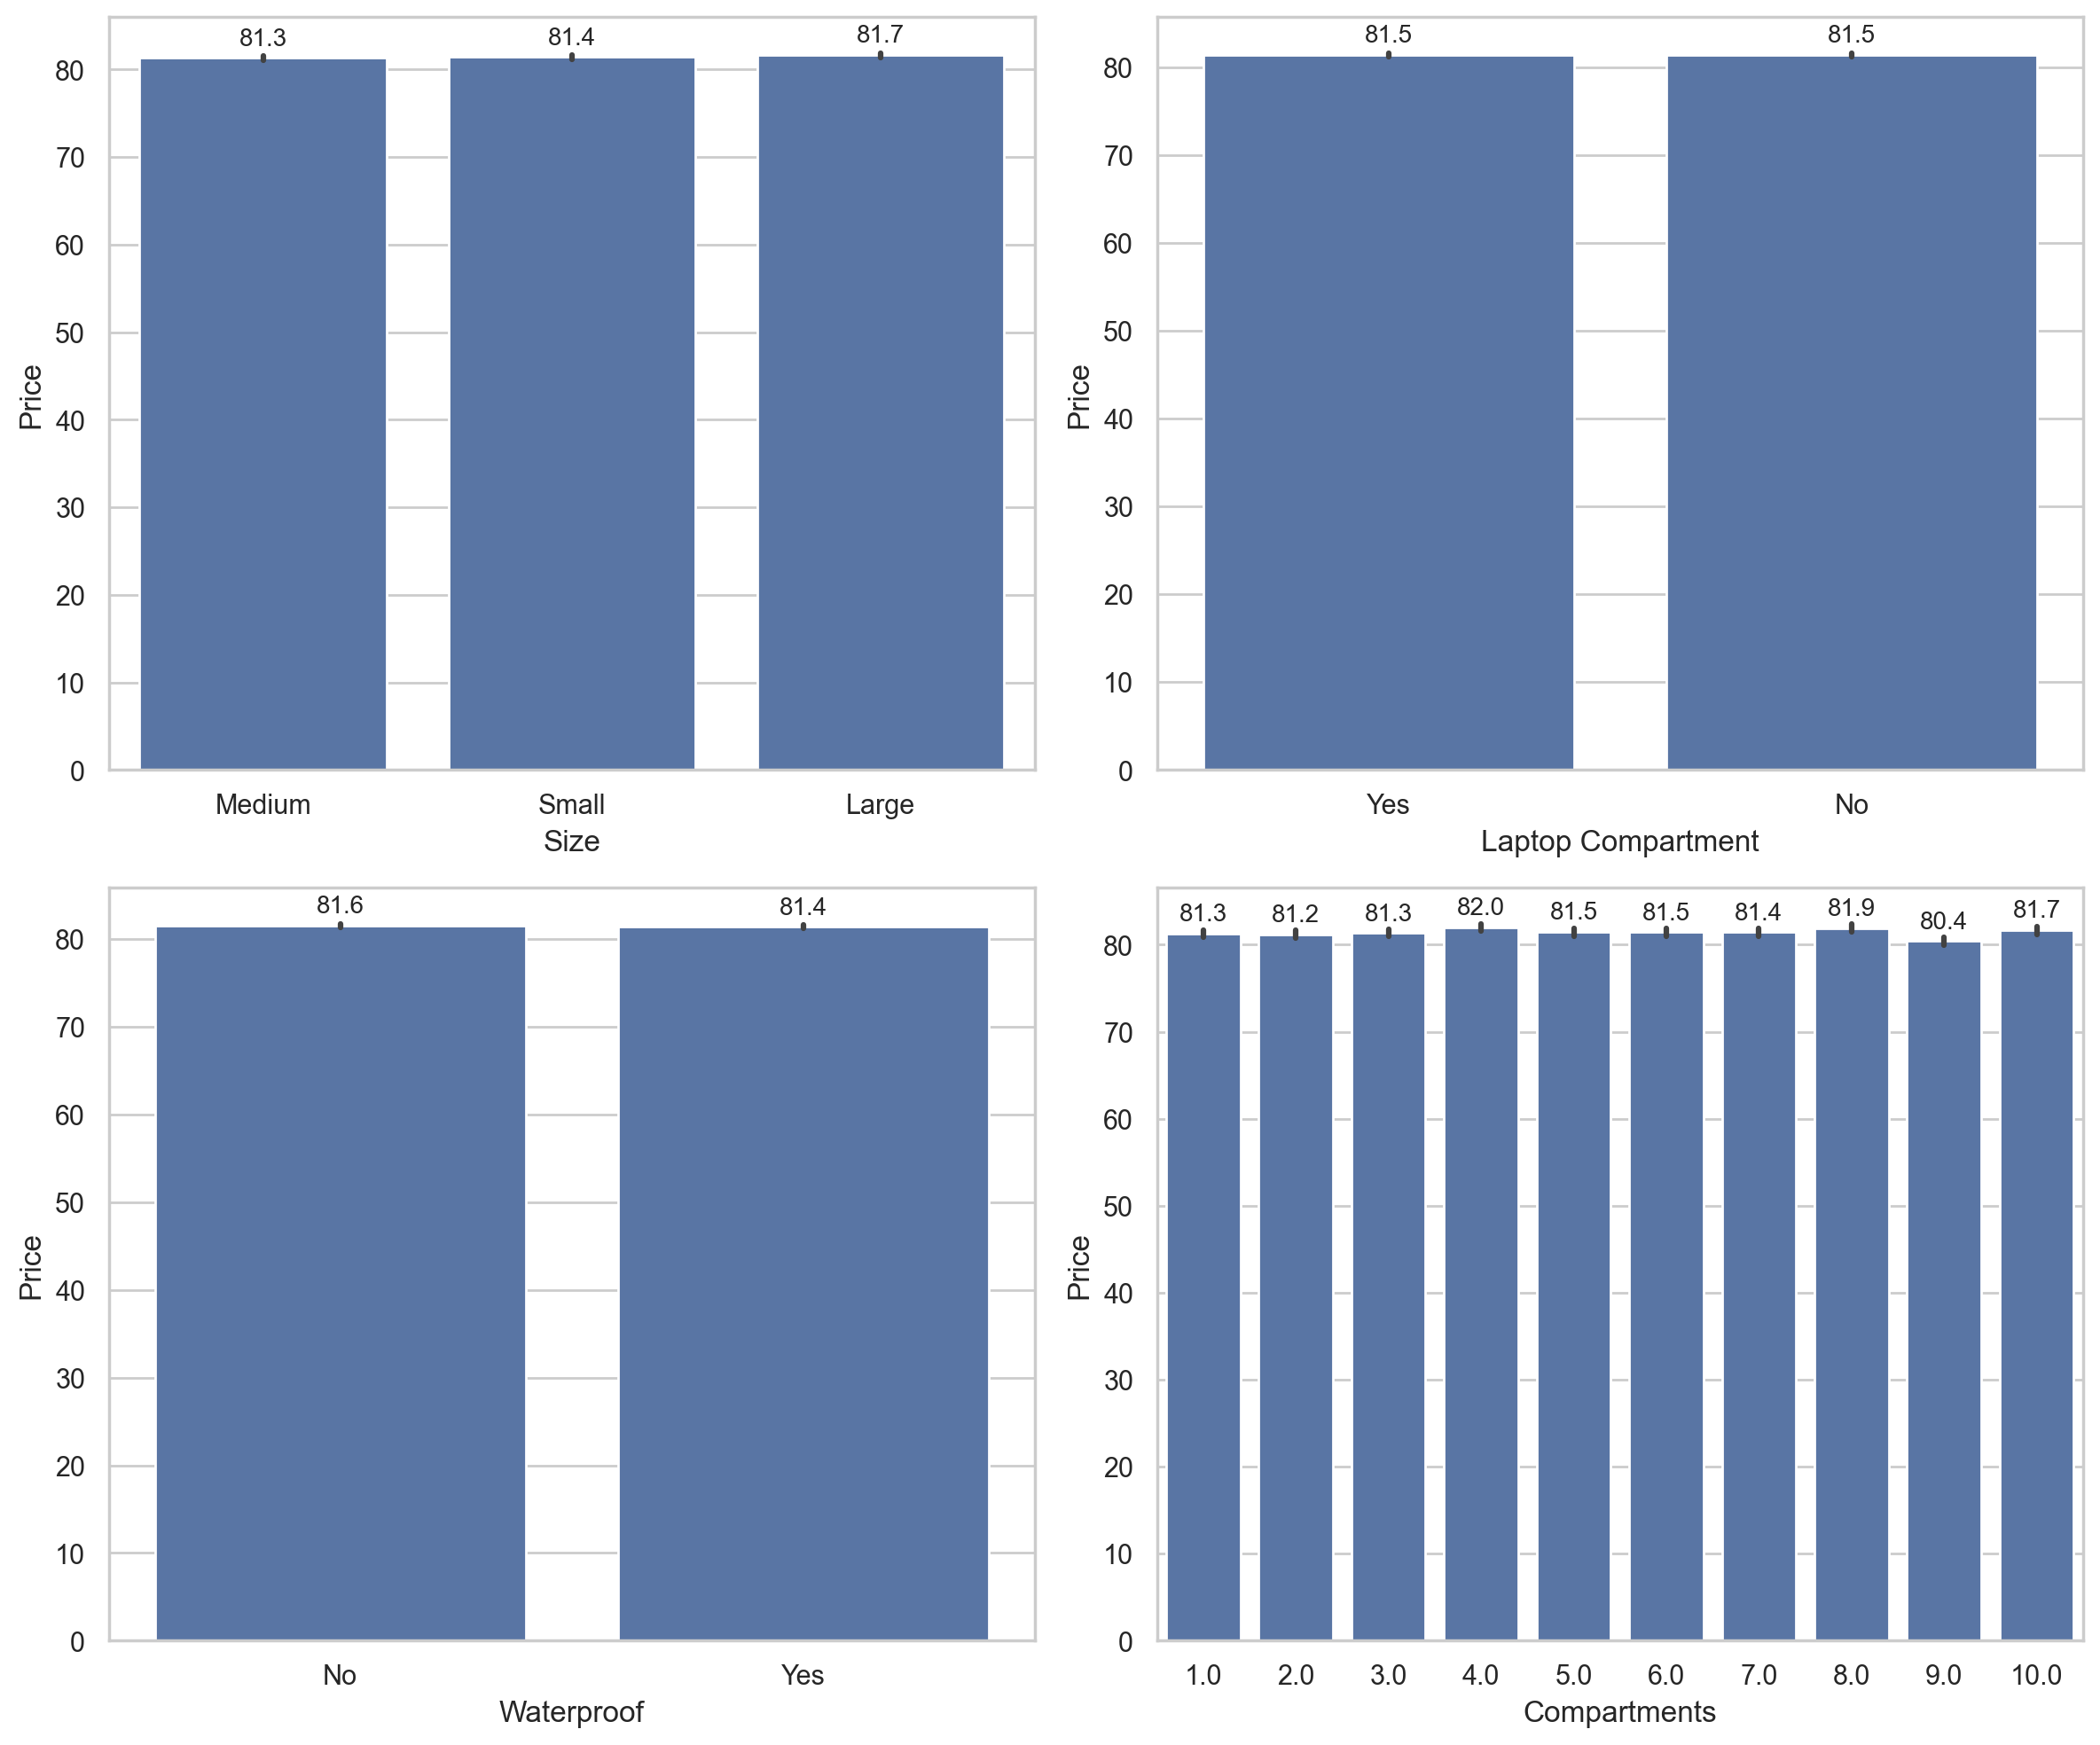

In [47]:
categorical_columns = ['Size', 'Laptop Compartment', 'Waterproof', 'Compartments']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax = axes[row, col]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

Large packs seem to cost a little more than both small and medium which makes sense as more material is needed to create them.
Laptop compartment does not seem to be indivative of cost
Non waterproof backpacks seem to cost more than waterproof backpacks. Could be a product of designer or nicer backpacks costing more than utility.
Number of compartments: 

10:00:35 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:00:36 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


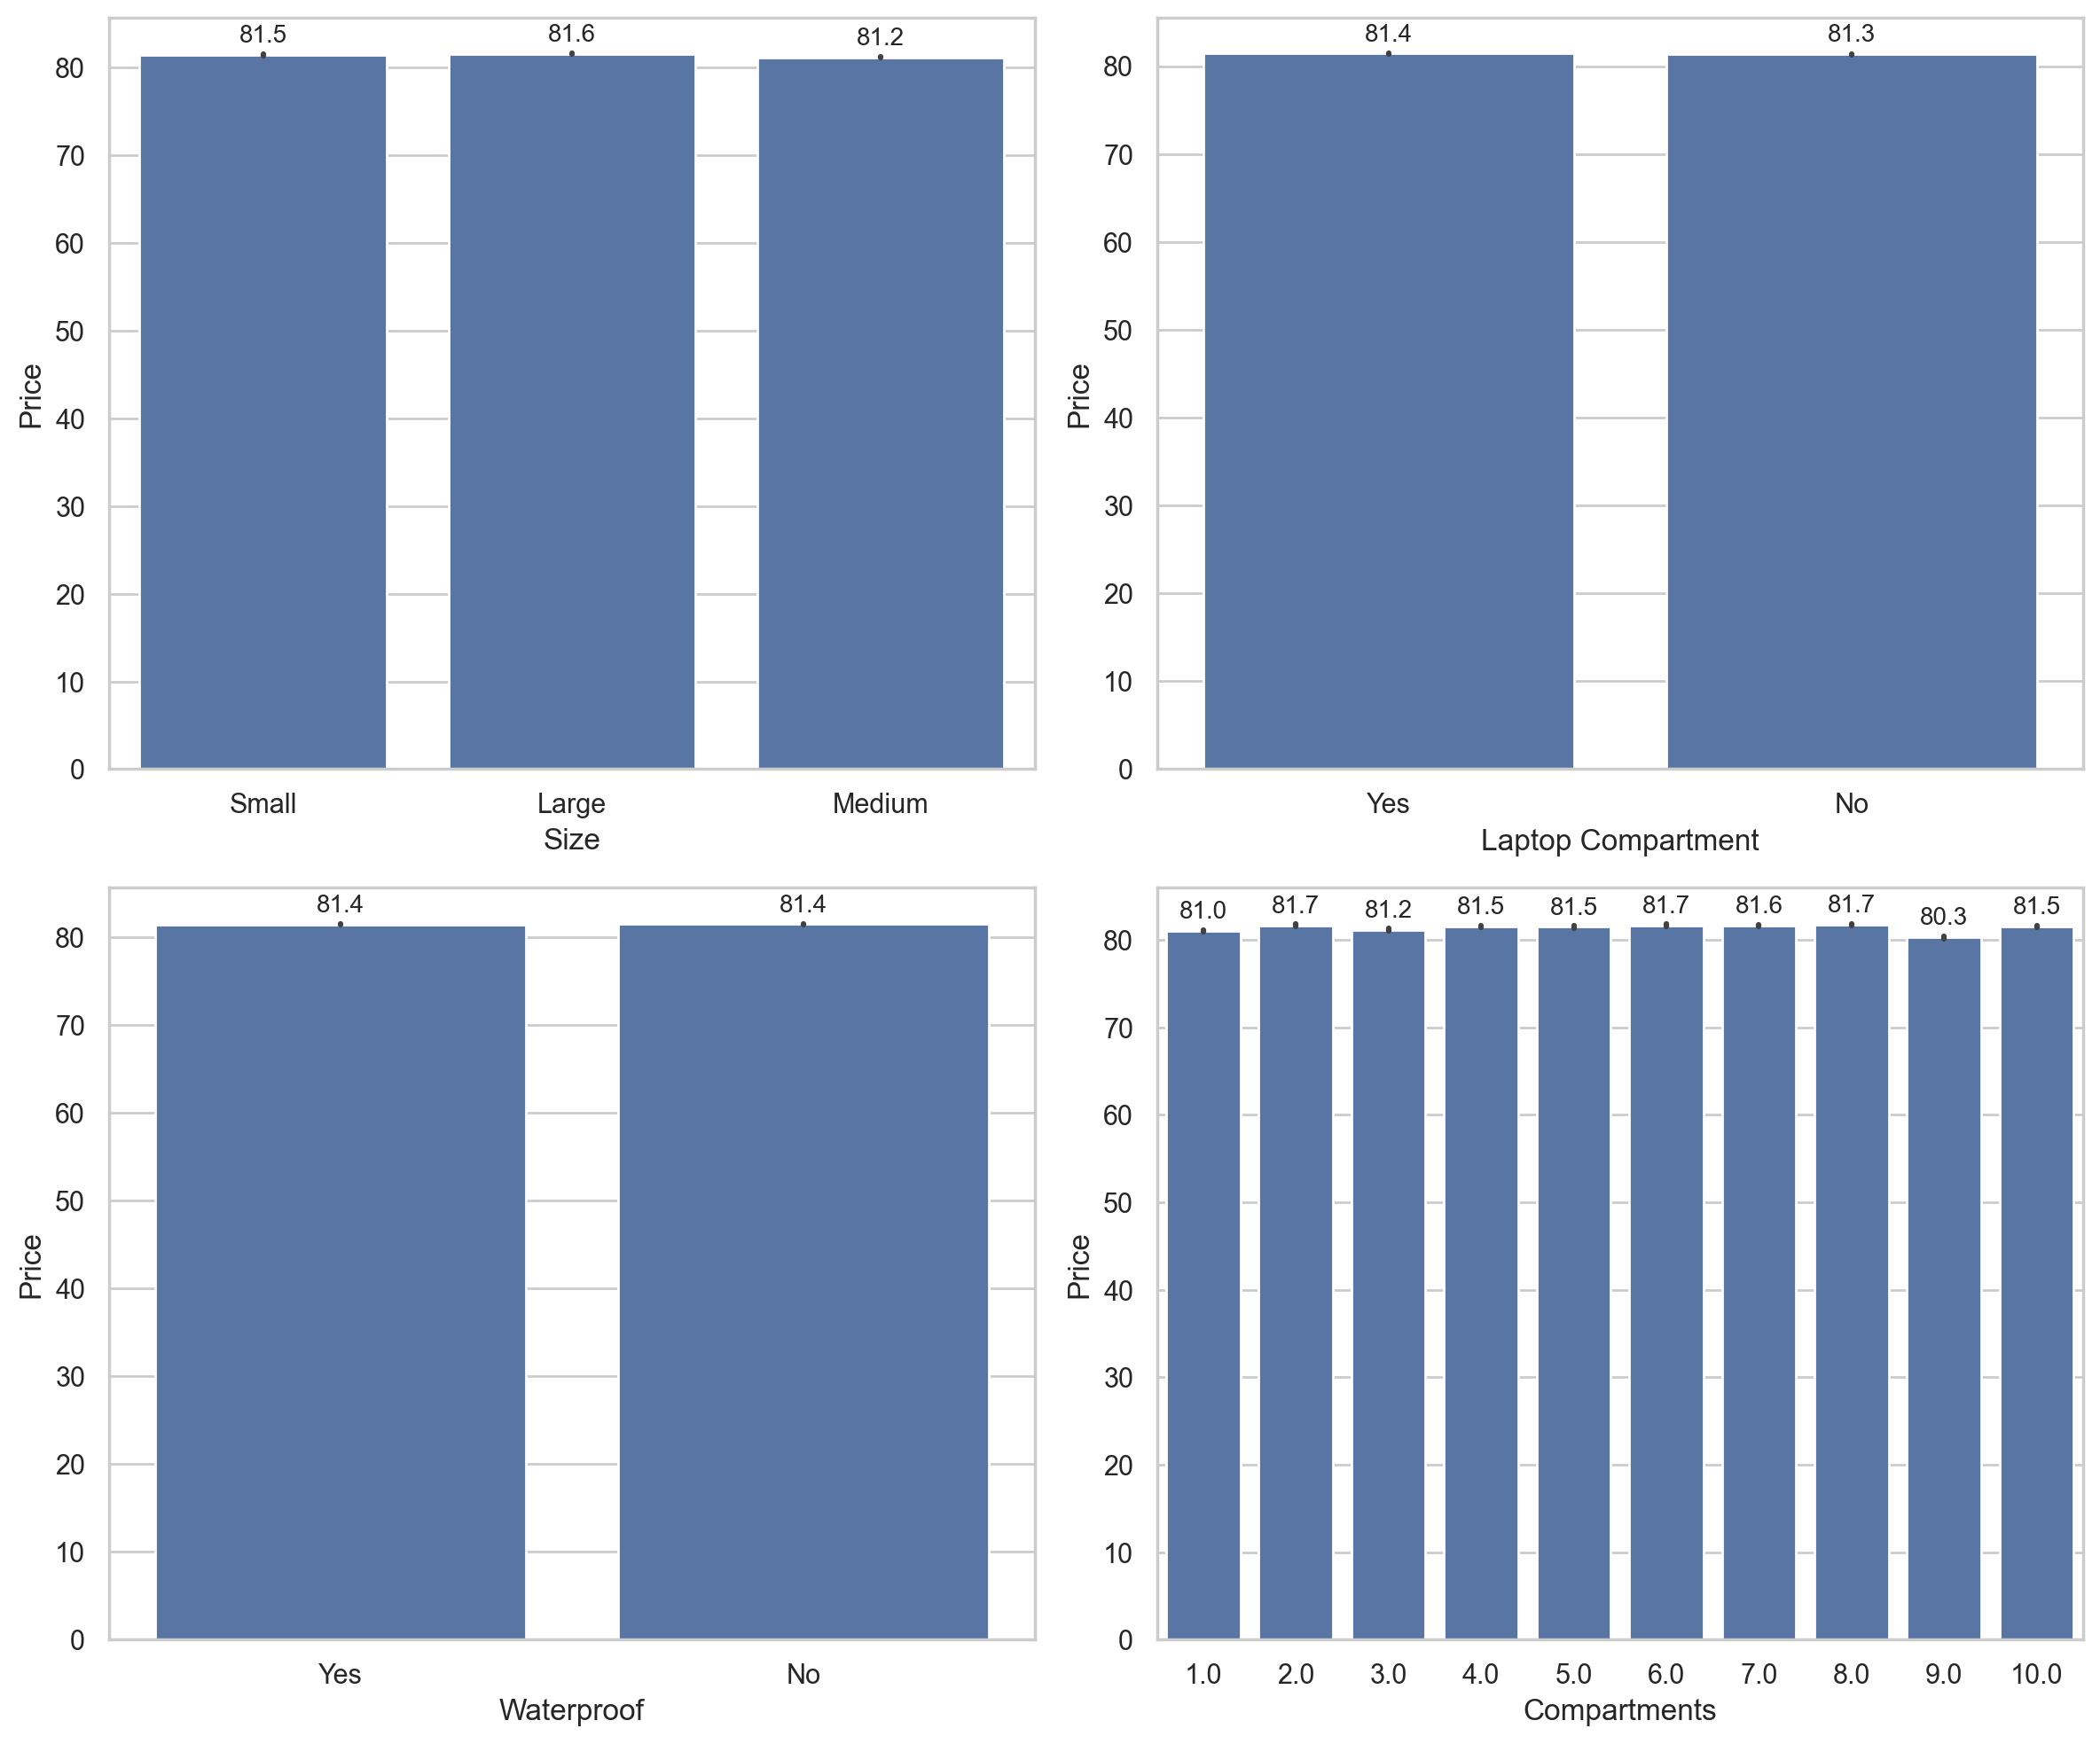

In [58]:
categorical_columns = ['Size', 'Laptop Compartment', 'Waterproof', 'Compartments']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax = axes[row, col]
  barplot = sns.barplot(data=train2, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

10:02:31 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
10:02:31 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


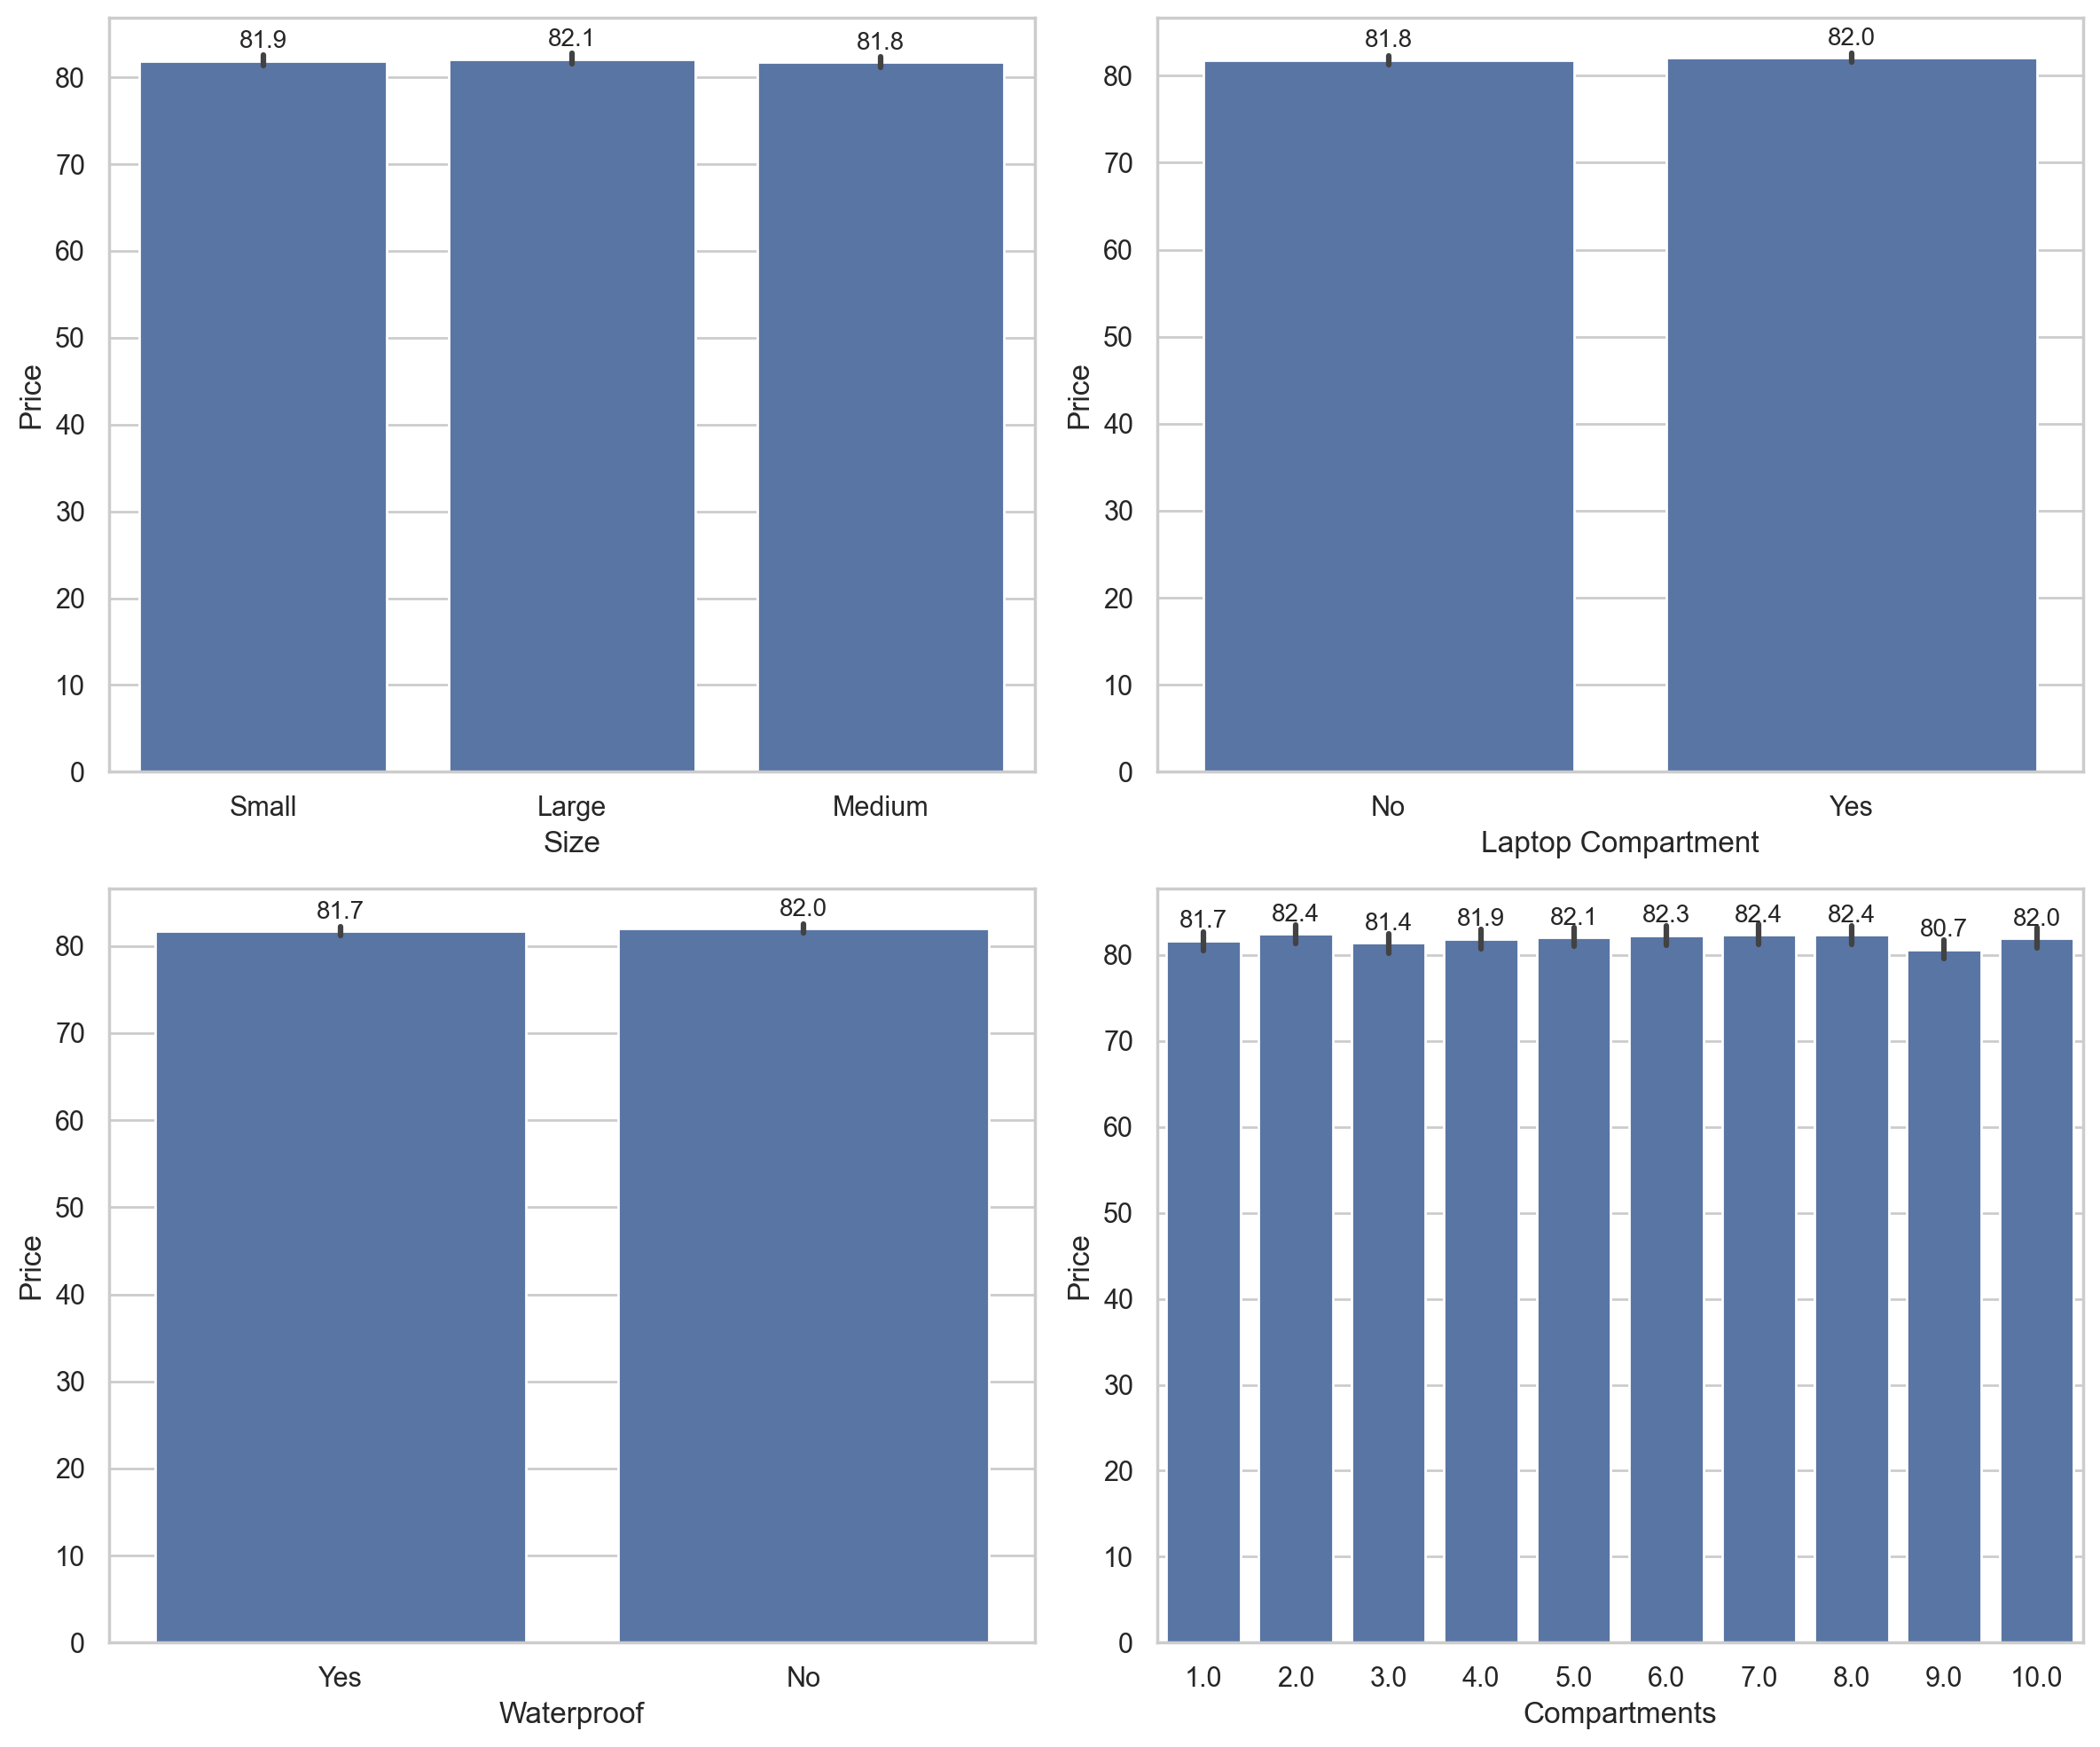

In [59]:
categorical_columns = ['Size', 'Laptop Compartment', 'Waterproof', 'Compartments']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax = axes[row, col]
  barplot = sns.barplot(data=train3, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

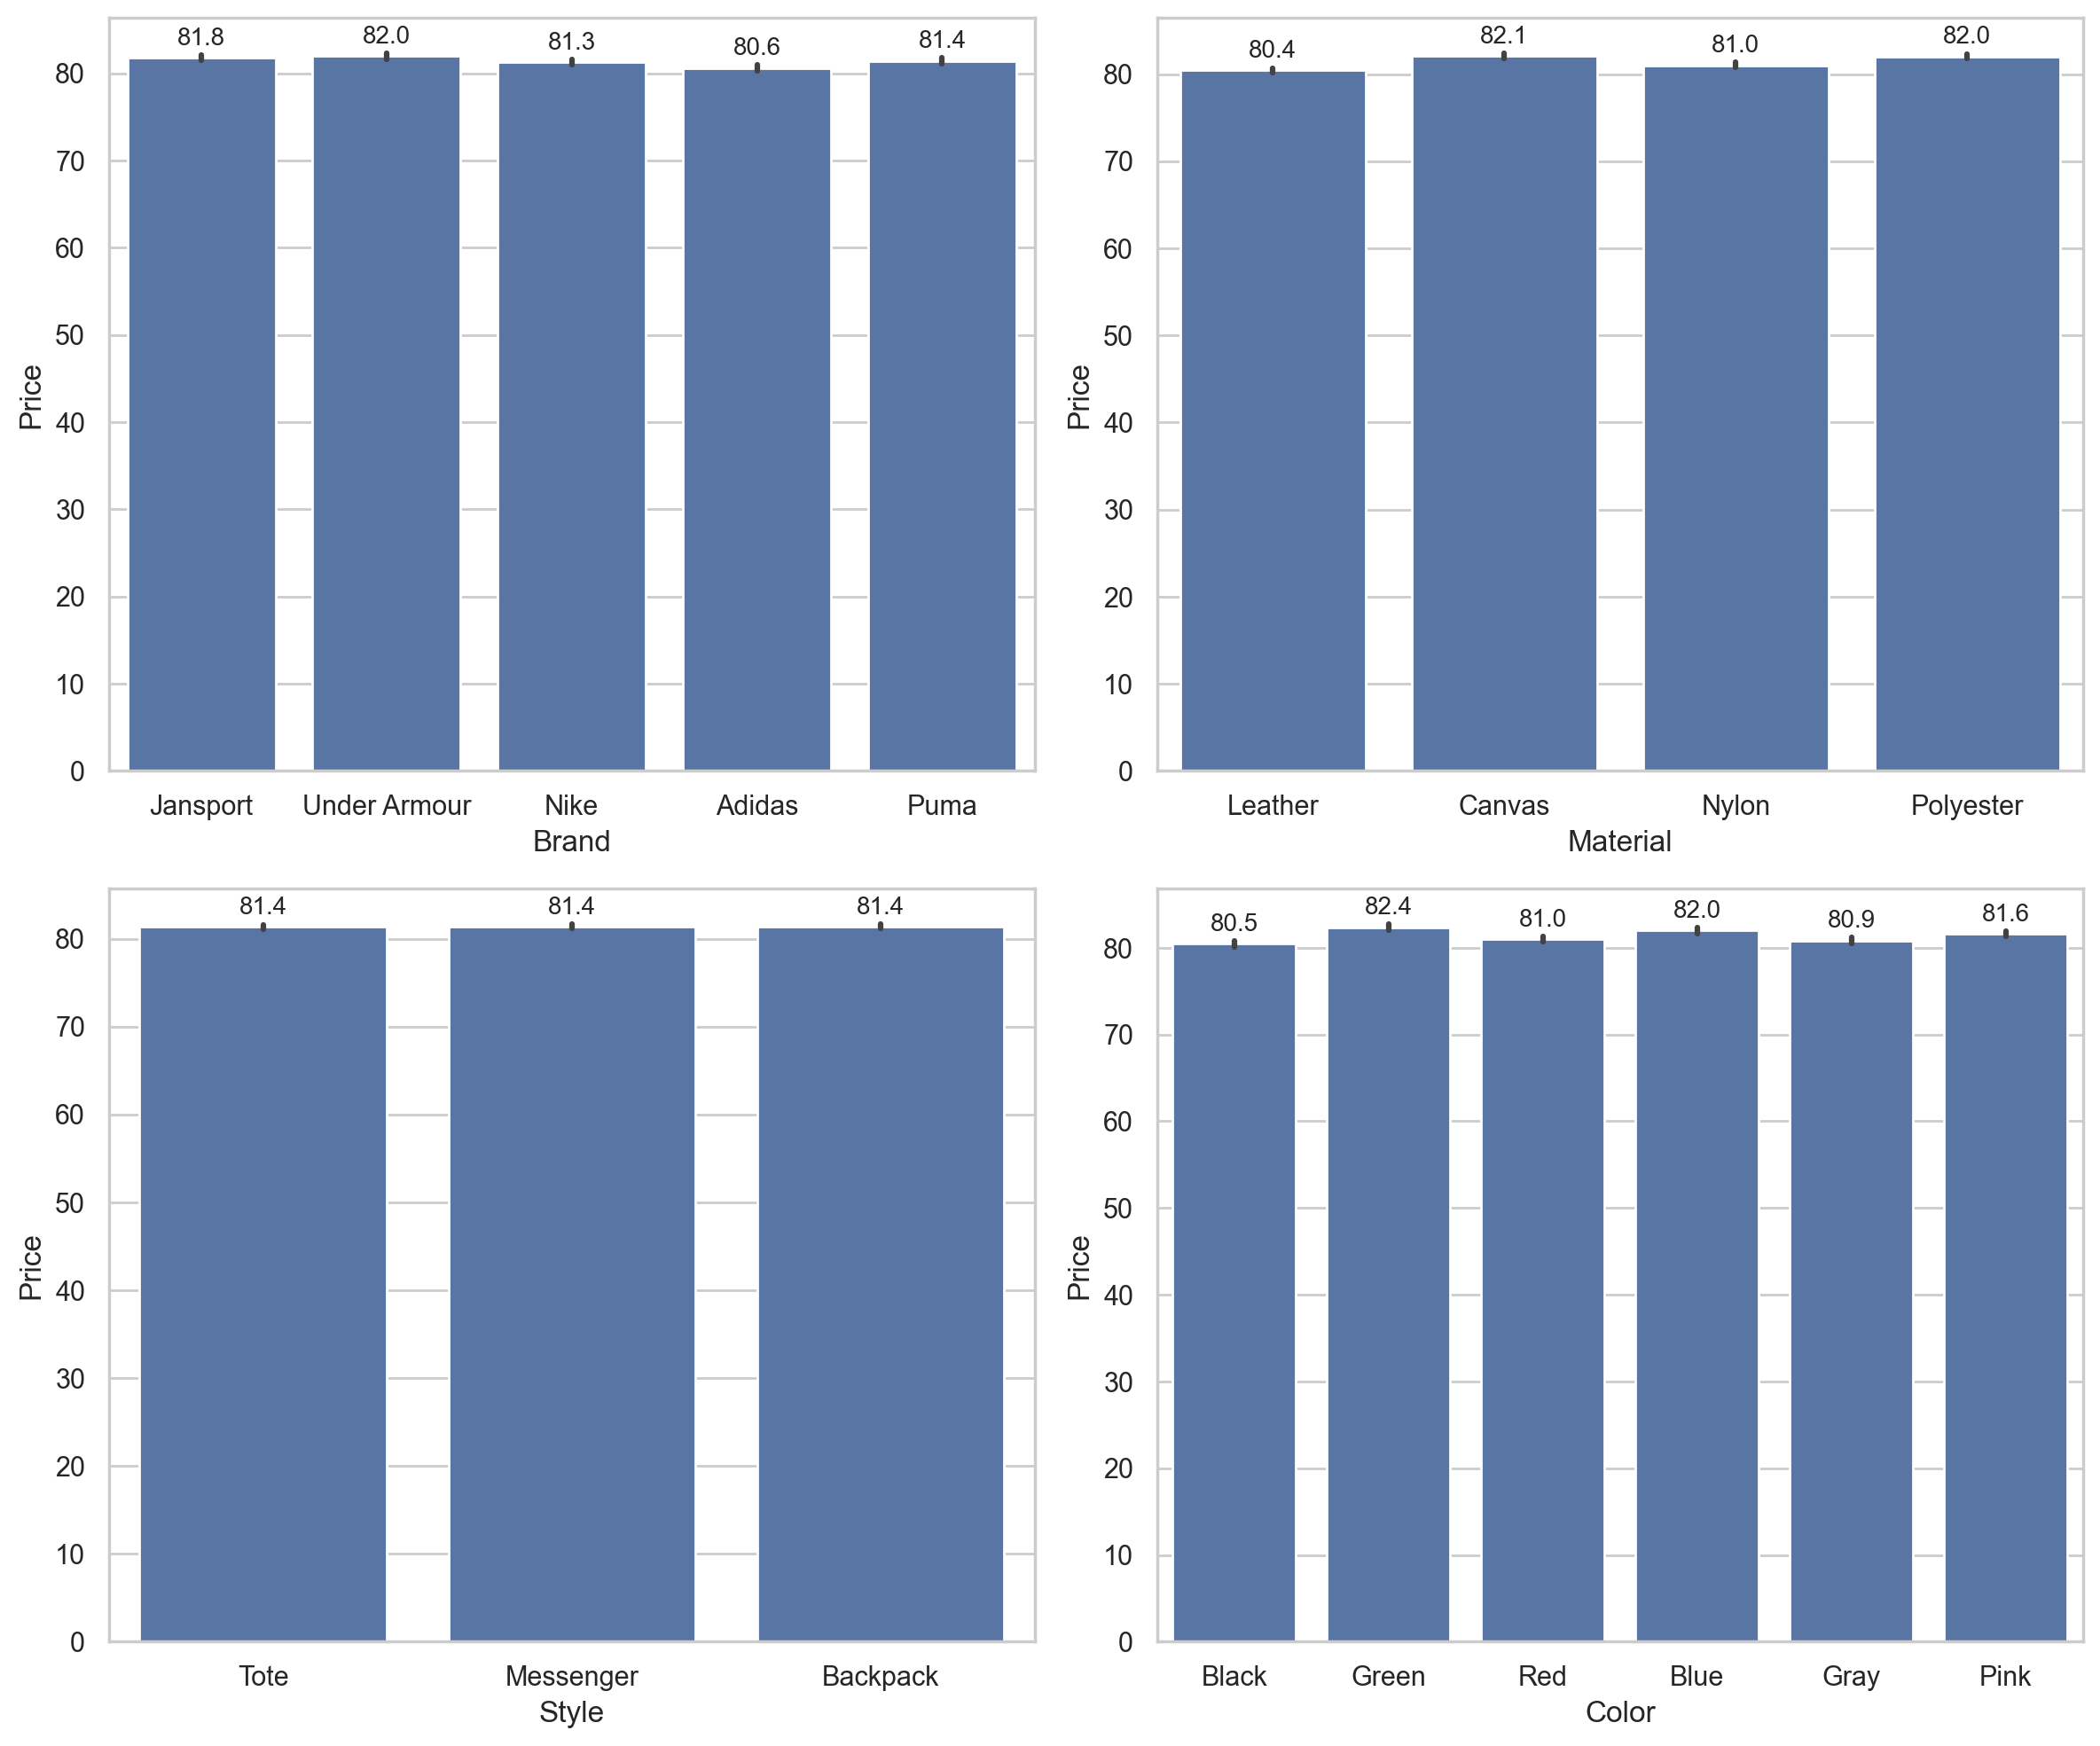

In [50]:
categorical_columns = ['Brand', 'Material', 'Style', 'Color']

fig, axes = plt.subplots(2,2,figsize=(12, 10))
for i, categorical_column in enumerate(categorical_columns):
  row, col = divmod(i, 2)
  ax=axes[row, col]
  barplot = sns.barplot(data=train1, x=categorical_column, y='Price', ax=ax)
  for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", fontsize=10, padding=3)
plt.tight_layout()

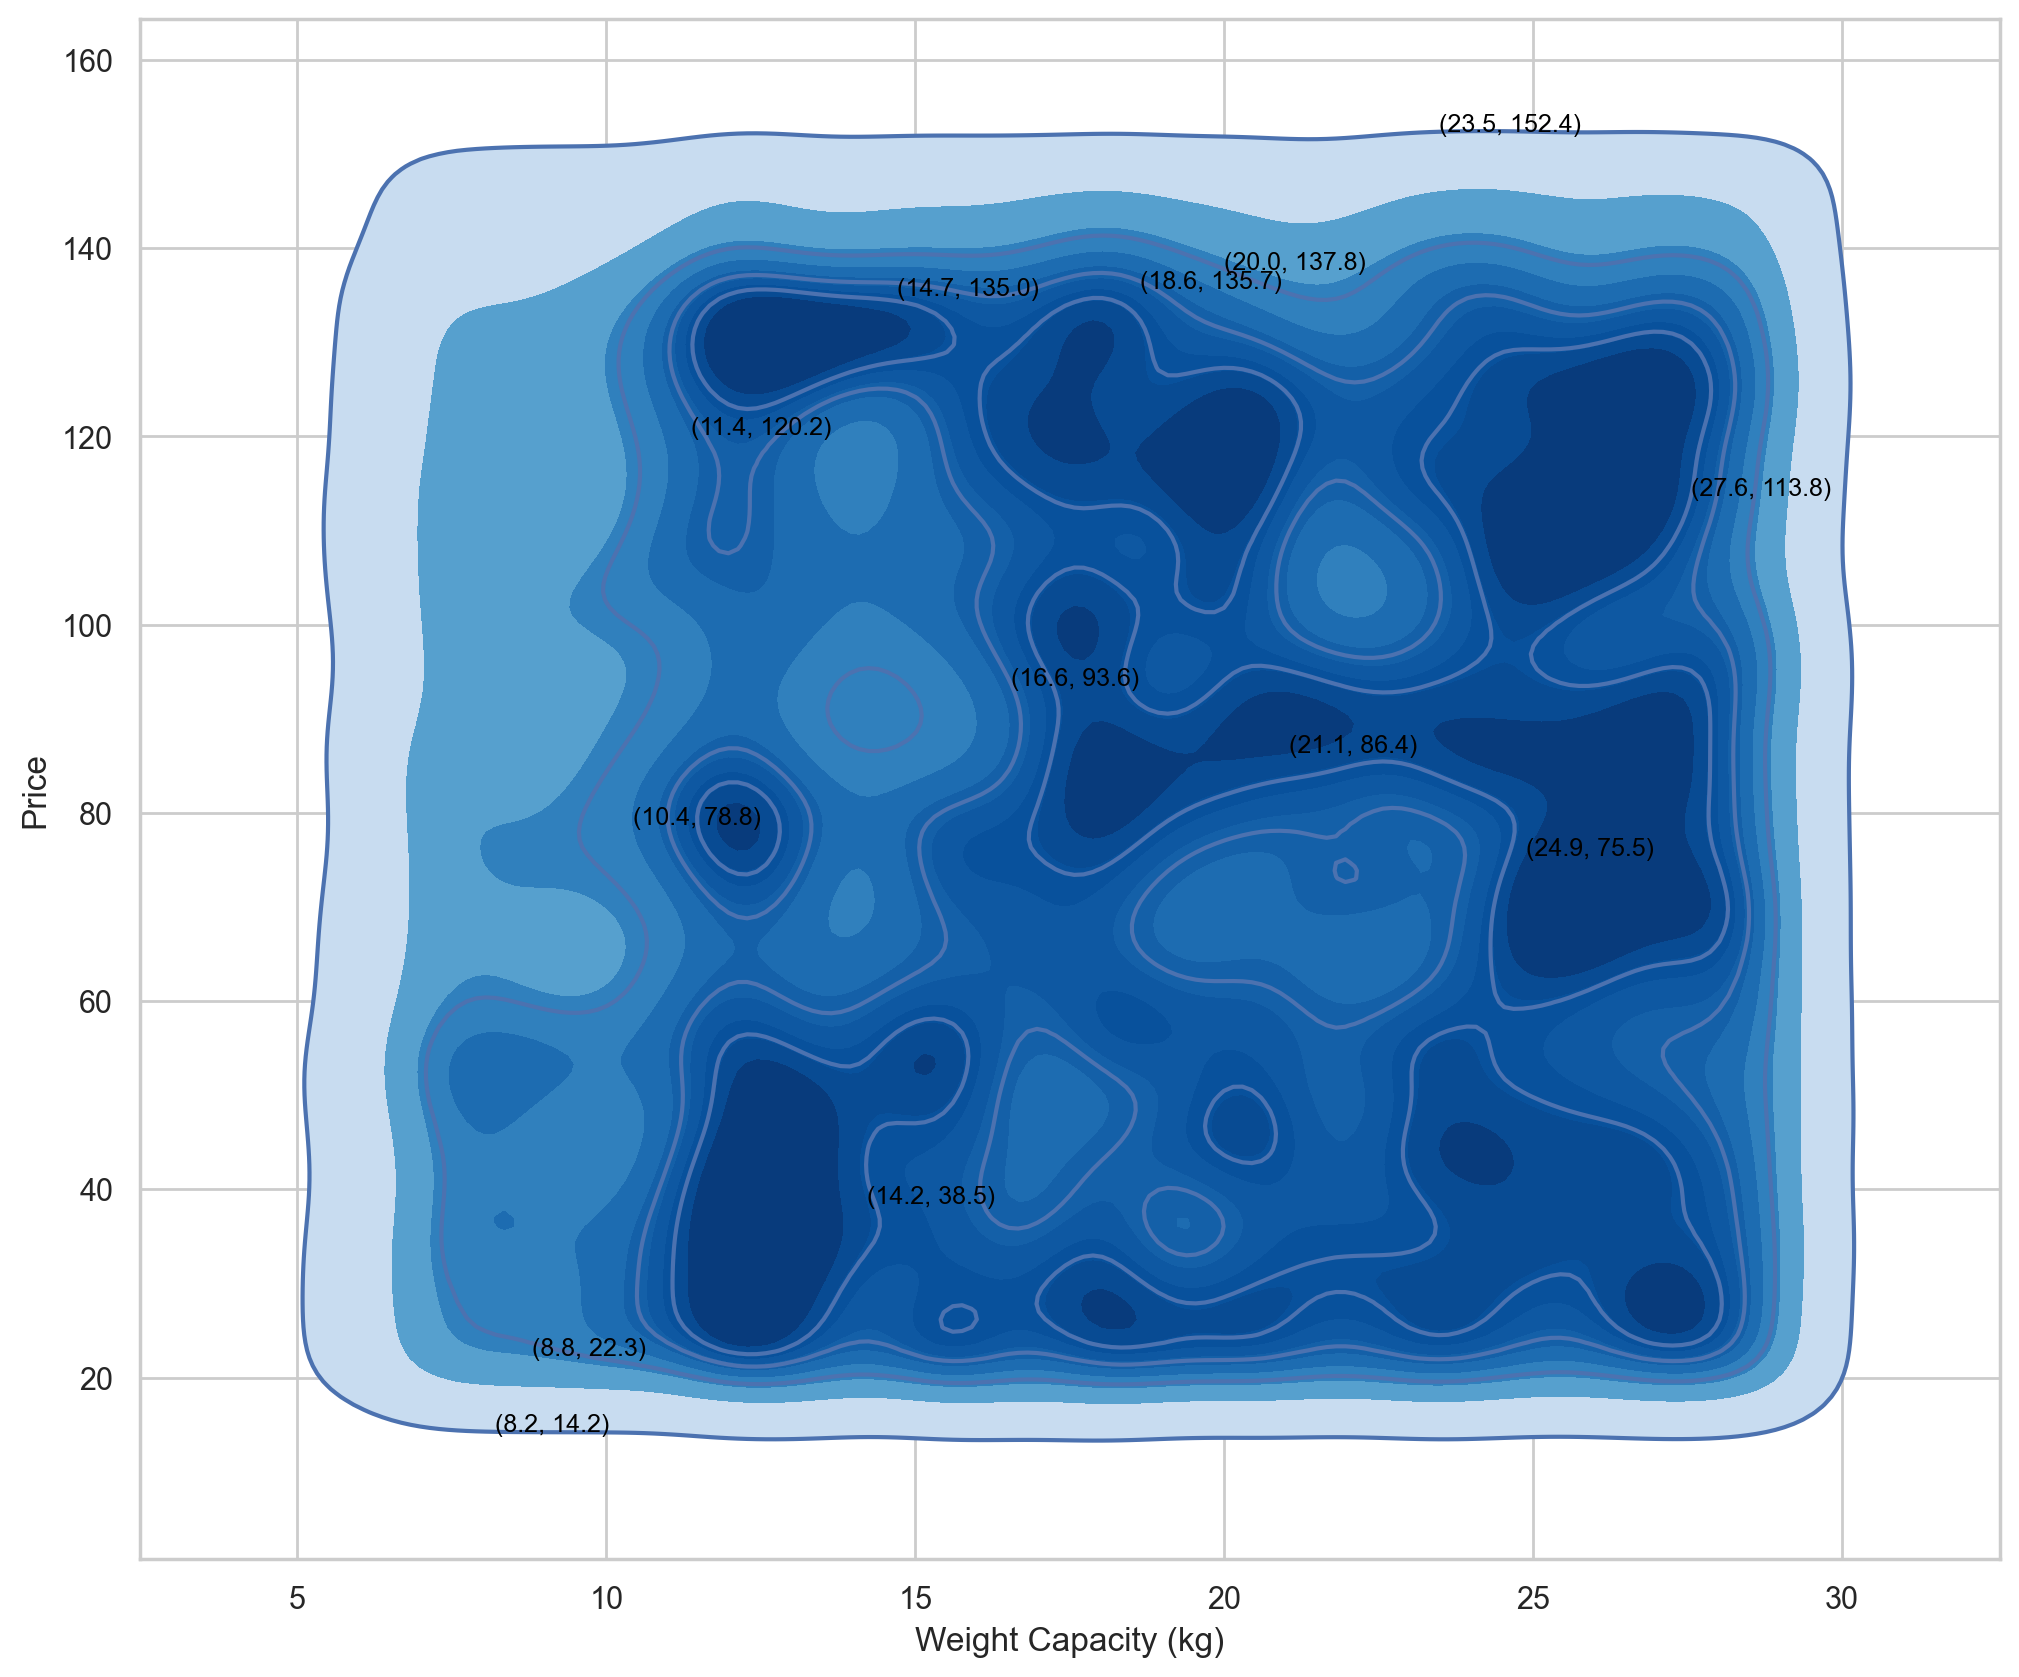

In [56]:
discrete_columns = ['Compartments', 'Weight Capacity (kg)']
plt.figure(figsize=(12, 10))
ax = sns.kdeplot(data=train1, x='Weight Capacity (kg)', y = 'Price', fill=True, cmap='Blues', thresh=0.05, levels=10)
x_vals = train1['Weight Capacity (kg)']
y_vals = train1['Price']

kde = sns.kdeplot(data=train1, x='Weight Capacity (kg)', y='Price', levels=5)
contours = kde.collections

for collection in contours:
  for path in collection.get_paths():
    verts=path.vertices
    if len(verts) > 0:
      x, y = verts[len(verts) // 2]
      ax.text(x, y, f"({x:.1f}, {y:.1f})", fontsize=9, color='black')

plt.show()

Dealing with missing Values


In [61]:
print('Missing Values:')
display(pd.concat([
  train1.iloc[:, 1:].isna().sum().rename('train'),
  test.isna().sum().rename('test')
], axis=1))

Missing Values:


,train,test
Brand,9705.0,6227.0
Material,8347.0,5613.0
Size,6595.0,4381.0
Compartments,0.0,0.0
Laptop Compartment,7444.0,4962.0
Waterproof,7050.0,4811.0
Style,7970.0,5153.0
Color,9950.0,6785.0
Weight Capacity (kg),138.0,77.0
Price,0.0,NaN
